# 1 Introduction

This notebook will be used to continue our Exploratory Data Analysis using inferential statistics, both on a team level and a player level.

### 1.0.1 Imports

Import libraries and write settings here.

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from random import sample
from tqdm import tqdm
import warnings
#warnings.simplefilter("ignore", UserWarning)

import pandas as pd

In [43]:
from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (10, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

## 1.1.1 Data

Read in data here.

In [44]:
drop = 'Unnamed: 0'

teams = pd.read_csv('data/processed/teams_final.csv')
teams.drop(drop, axis = 1, inplace = True)
teams = teams[(teams.Year != 1998) &(teams.Year != 2011)] # remove abbreviated seasons
print('Teams df shape:',teams.shape)

players = pd.read_csv('data/processed/players_final.csv')

players = players[(players.salary.notnull()) 
                  & (players['Last Name'].notnull()) 
                  & (players['Dist.'].notnull()) 
                  & (players.GS > 20)
                  & (players.cluster.notnull())]
print('Players df shape:',players.shape)

Teams df shape: (1063, 38)
Players df shape: (3438, 75)


# 2 Analysis and Modeling

As with the other steps to this project, our analysis will also be divided into two separate and equally important parts: team-level analysis and player-level analysis.

## 2.1 Team-level

**Null hypothesis**: Spending more and spending less on your team results the same number of Wins.<br>
**Alternative hypothesis**: Spending more and spending less on your team does not result in the same number of wins.

In [45]:
split = 1.2  # represents 120% of the salary cap, chosen because it splits teams data points
# roughly in half

over = teams.loc[teams.portion >= split]
under = teams.loc[teams.portion < split]

print('Overpaid teams:', len(over), '\nUnderpaid teams', len(under))
print('Overpaid mean/std Wins:', round(over.W.mean(), 2), ',', round(np.std(over.W), 2),
      '\nUnderpaid mean/std Wins:', round(under.W.mean(), 2), ',', round(np.std(under.W), 2))

Overpaid teams: 242 
Underpaid teams 257
Overpaid mean/std Wins: 44.5 , 11.87 
Underpaid mean/std Wins: 38.46 , 12.18


An interesting note: our mark of team salaries 1.2 times the salary cap gave our groups average win counts right at our "make" and "miss" marks for the playoffs from our earliest analysis, 44 wins and 38 wins, respectively.

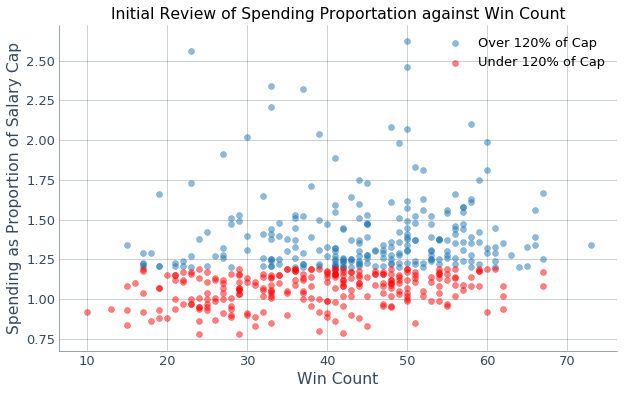

In [46]:
plt.scatter(over.W, over.portion, alpha=0.5)
plt.scatter(under.W, under.portion, color='red', alpha=0.5)
plt.ylabel('Spending as Proportion of Salary Cap')
plt.xlabel('Win Count')
plt.title('Initial Review of Spending Proportation against Win Count')
plt.legend(['Over 120% of Cap', 'Under 120% of Cap'])
plt.show()

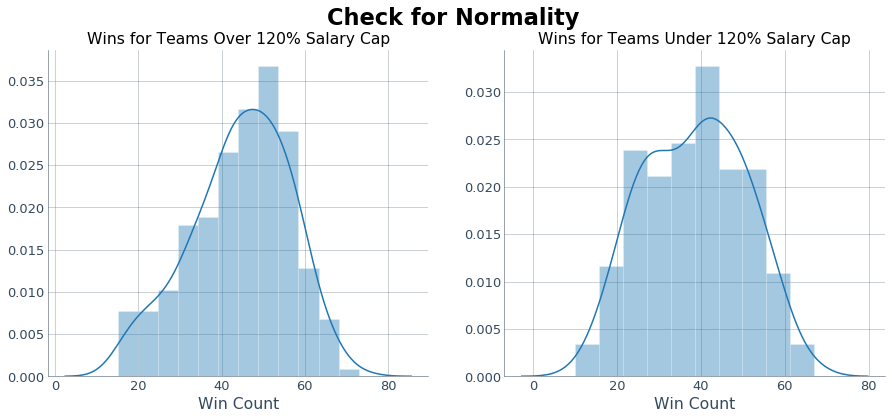

In [47]:
plt.subplots(1,2, figsize = (15,6))

plt.subplot(121)
sns.distplot(over.W)
plt.xlabel('Win Count')
plt.title('Wins for Teams Over 120% Salary Cap')
plt.subplot(122)
sns.distplot(under.W)
plt.xlabel('Win Count')
plt.title('Wins for Teams Under 120% Salary Cap')
plt.suptitle('Check for Normality')
plt.show()

In [56]:
# for loop to sample (with replacement) 30 teams from over and under then run 10,000 t-tests and take mean p-value
# plot histogram of wins to see normal distribution
# plot histogram of p-values
teams_T_list = []
teams_p_list = []
for i in tqdm(range(10000)):
    over_samp = sample(list(over.W), 30)
    under_samp = sample(list(under.W), 30)
    T, p = stats.ttest_ind(over_samp,
                           under_samp,
                           equal_var=False)
    teams_T_list.append(T)
    teams_p_list.append(p)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1375.42it/s]


With a mean p-value of 0.15, we actually fail to reject our null hypothesis that teams paying over and teams paying under 120% of the salary cap achieve different win totals. This is to say: there is no significant difference in wins between teams paying over 120% of the salary cap and teams paying under 120% of the salary cap. In simpler terms: *money doesn't buy wins*.

## 2.2 Player-level

In [49]:
clusterlist = players.cluster.unique()
clusterlist

array(['Rim Protector', 'Skilled Big', 'Scoring Forward',
       'Slasher Shot Creator', 'Lockdown', 'Two Way Threat',
       'Combo Guard', 'Floor General'], dtype=object)

In [50]:
# mean Player Efficiency Rating is set to be normalized around 15
# are some clusters on average more efficient than others?
# null: no cluster mean PER is significantly different than mean PER of all players
# alt: there is/are cluster(s) whose mean PER is significantly greater than mean PER of all players
# alpha = 0.05

mean = np.mean(players.PER)
std = np.std(players.PER)

print('Population mean PER:',round(mean,1))
print('Population PER std: +/-',round(std,1))

Population mean PER: 15.5
Population PER std: +/- 4.3


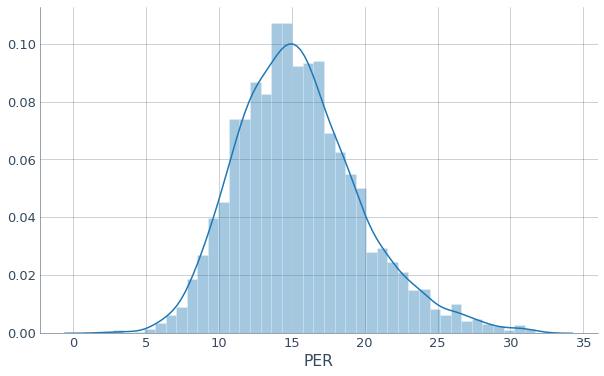

In [51]:
sns.distplot(players.PER)
plt.show()

In [52]:
players.columns

Index(['Full Name', 'Pos', 'cluster', 'index', 'Last Name', 'First Name', 'Year', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'ORtg', 'DRtg', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'salary', 'Dist.', '2P_A', '0-3_A', '3-10_A', '10-16_A', '16-3pt_A', '3P_A',
       '0-3%', '3-10%', '10-16%', '16-3pt%', 'Astd_2P', 'Dunk%', 'Dunks_Md', 'Astd_3P', '%Corner3_A', 'Corner_3P%', 'Heaves_A', 'Heaves_Md'],
      dtype='object')

In [53]:
clusterlist = players.cluster.unique()
value_stats = ['PER', 'WS', 'BPM', 'VORP', 'USG%', 'PTS']
confidence = 0.05 * 2

for h in value_stats:
    
    pop_mean = np.mean(players[h])

    for i in tqdm(clusterlist):

        players_T_list = []
        players_p_list = []
        cluster = list(players[players.cluster == i][h])

        for j in range(10000):

            cluster_samp = sample(cluster, 30)
            T, p = stats.ttest_1samp(cluster_samp, pop_mean)
            players_T_list.append(T)
            players_p_list.append(p)

        T = np.mean(players_T_list)
        p = np.mean(players_p_list)

        if p <= confidence:
            print('Cluster: {};\tValue Stat: {}'.format(i, h))
            print('Sample mean {}:'.format(h), round(np.mean(cluster_samp),
                                                     2), 'Population mean {}:'.format(h), round(pop_mean, 2))
            print('Test statistic (T):', round(T, 2), 'p-value:', round(p, 3))
            print('Reject the null. Significant difference in mean {} between population and the {} cluster.'.format(h, i))
            if T < 0:
                print('For the {} cluster, mean {} is lower than the league average.'.format(i, h))
            else:
                print('For the {} cluster, mean {} is above the league average.'.format(i, h))

 50%|██████████████████████████████████████████                                          | 4/8 [00:13<00:13,  3.32s/it]

Cluster: Lockdown;	Value Stat: PER
Sample mean PER: 13.84 Population mean PER: 15.49
Test statistic (T): -4.38 p-value: 0.008
Reject the null. Significant difference in mean PER between population and the Lockdown cluster.
For the Lockdown cluster, mean PER is lower than the league average.


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Cluster: Rim Protector;	Value Stat: USG%
Sample mean USG%: 16.77 Population mean USG%: 20.16
Test statistic (T): -2.93 p-value: 0.055
Reject the null. Significant difference in mean USG% between population and the Rim Protector cluster.
For the Rim Protector cluster, mean USG% is lower than the league average.


 75%|███████████████████████████████████████████████████████████████                     | 6/8 [00:16<00:05,  2.83s/it]

Cluster: Combo Guard;	Value Stat: USG%
Sample mean USG%: 23.31 Population mean USG%: 20.16
Test statistic (T): 2.36 p-value: 0.088
Reject the null. Significant difference in mean USG% between population and the Combo Guard cluster.
For the Combo Guard cluster, mean USG% is above the league average.


  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

Cluster: Rim Protector;	Value Stat: PTS
Sample mean PTS: 20.48 Population mean PTS: 21.66
Test statistic (T): -2.61 p-value: 0.082
Reject the null. Significant difference in mean PTS between population and the Rim Protector cluster.
For the Rim Protector cluster, mean PTS is lower than the league average.


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.81s/it]


In the above loops, we ran one-sample t tests on our prevailing "value statistics" for each cluster. The loop structure looped through each unique value statistic (of which there were 6); within each loop it looped through each cluster (of which there are 8); with each cluster, 10,000 t tests were performed, taking random samples of 30 players from the cluster each time and testing the mean of the value statistic for that sample. These test statistics and correlary p-values were averaged, and if any p-values of less that 0.10 (our confidence level) were produced, they were flagged and printed out. In all, nearly 50,000 loops were run in roughly 120 seconds. #python

# 3 Results

With our team-level inferential statistics, two sample t-tests of independence showed us that money doesn't buy wins--at least not at a statistically significant level. The differences in mean Win count for teams paying over 120% of the salary cap for any given year, and teams paying under 120% of the salary cap for any given year varied greatly--44 and 38, respectively. **However**, when we sampled from these groups and ran a few t-tests (read: ten thousand t-tests), we saw that that this difference was not in fact significant at even a 0.10 confidence. The resultant p-values were plotted in the histogram below.

Mean Test Statistic (T): -6.345755228556812
Mean p-value: 0.15204114890444317


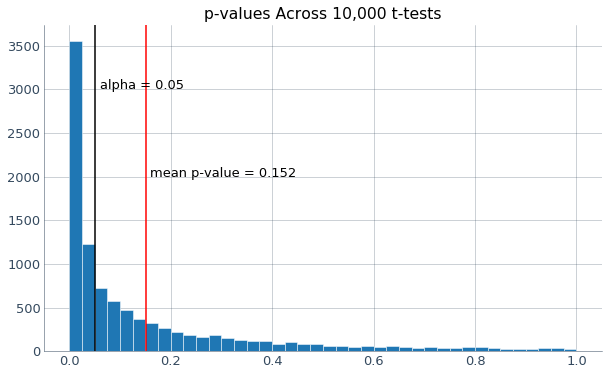

In [55]:
print('Mean Test Statistic (T):', np.mean(T_list))
print('Mean p-value:', np.mean(teams_p_list))
plt.hist(teams_p_list, bins=40)
plt.axvline(np.mean(teams_p_list), color='red')
plt.axvline(0.05, color='black')
plt.text(0.06, 3000, 'alpha = 0.05')
plt.text(0.16, 2000, 'mean p-value = '+str(round(np.mean(teams_p_list), 3)))
plt.title('p-values Across 10,000 t-tests')

plt.show()

On the player-level, we ran one-sample t-tests (quite a few) to search for statistical significance in our "value statistics" among clusters. What we found was interesting:<br>
- the "Lockdown" cluster was flagged for statistically lower mean Player Efficiency Rating (PER)
- "Rim Protectors" were flagged for having statistically lower mean Usage Rate (USG%)
- "Combo Guards" were conversely flagged for statistically higher mean Usage Rate
- "Rim Protectors" were the only cluster with a significant difference (lower) in Points Scored (PTS)

Crudely, Player Efficiency Rating increases when a player does something right and decreases when a player does something wrong. On average, the "Lockdown" cluster is not balancing out their mistakes with their contributions.

Usage Rate is an interesting advanced statistic. Read [here](https://www.nbastuffer.com/analytics101/usage-rate/) for some more insights. Usage is essentially a statistic of player involvement--how often the player touches the ball. Overall, we see that usage and efficiency are inversely related. According to NBAstuffer "players perform more efficiently when they are asked to use fewer of their team’s possessions. As a result, the greater burden on the superstar means that supporting players maintain low usage rates, allowing them to operate closer to their peak efficiency." This explains why the Usage Rates among our cluster "Combo Guards" is higher on average, as this cluster is composed largely of the type of player who wants the ball in his hands.

Last, while our "Rim Protectors" cluster showed signicantly lower mean Points Scored, this shouldn't be super revealing, as the main purpose of this type of player is not shoulder the load on scoring, but to provide indirect contributions in the form of rebounds, blocks, and overall discouragement to the opposing team to come close to the basket.



# 4 Conclusions and Next Steps

On the team level, it'd be helpful to find a spending level (relative to the salary cap) at which win count is significantly different. While it is encouraging that 120% didn't give us statistical significance, we can't conclude that, for example, teams should feel comfortable spending below 110% or 100% of the salary cap. We have no evidence to support decreased spending past our one marker of 120%.<br><br>
On the player level, we could theoretically run this type of t-test loop for most of our other features (such as 3P%, one we've found to be an important correlate with Winning), but with more appropriate populations. For example, with the feature '3P%' in particular, it wouldn't be wise to include the "Rim Protector" cluster data when determining population mean. This type of insight would vary from feature to feature, and thus would need much more code.